Simply QNN

In [13]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Time series data
time = np.arange(0, 1000, 1)
demand = 0.05 * time + np.sin(time * 0.1) + np.random.normal(0, 0.5, size=len(time))

# Synthetic features
population = np.linspace(50, 60, num=len(time)) + np.random.normal(0, 1, size=len(time))  # Growing population
temperature = 20 + 10 * np.sin(time * 0.01) + np.random.normal(0, 2, size=len(time))  # Seasonal temperature
sunlight = 5 + 3 * np.sin(time * 0.05) + np.random.normal(0, 0.5, size=len(time))  # Varied sunlight exposure

# Stack features together
features = np.stack([time, population, temperature, sunlight, demand], axis=1)

# Shift demand to create a prediction task
X = features[:-1]  # All but last
Y = features[1:, -1]  # Demand shifted by one

# Split into training and testing sets
split_time = 800
X_train, X_test = X[:split_time], X[split_time:]
Y_train, Y_test = Y[:split_time], Y[split_time:]
# Assuming Y_train and Y_test are your original demand values
Y_train_expanded = np.tile(Y_train, (3, 1)).T  # Replicate Y_train across 3 columns
Y_test_expanded = np.tile(Y_test, (3, 1)).T  # Replicate Y_test across 3 columns

Y_train_torch = torch.tensor(Y_train_expanded, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test_expanded, dtype=torch.float32)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

# DataLoader for training data
train_dataset = TensorDataset(X_train_torch, Y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


Training completed.


In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

# Model Definition
class QuantileModel(nn.Module):
    def __init__(self):
        super(QuantileModel, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # Assuming 5 input features
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, 3)  # Outputting 3 quantiles

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

# Quantile Loss Function
def quantile_loss(q, y, f):
    e = y - f
    v = torch.max(q * e, (q-1) * e)
    return torch.mean(v)

# Assuming synthetic data creation and preprocessing has been done correctly
# Example: X_train, Y_train, X_test, Y_test

# Preparing target data for three quantiles
Y_train_expanded = np.tile(Y_train, (3, 1)).T  # Replicate Y_train across 3 columns
Y_test_expanded = np.tile(Y_test, (3, 1)).T  # Replicate Y_test across 3 columns

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train_expanded, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test_expanded, dtype=torch.float32)

# DataLoader for training data
train_dataset = TensorDataset(X_train_torch, Y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Model Initialization
model = QuantileModel()

# Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = sum([quantile_loss(torch.tensor([q]), y_batch[:, i], output[:, i]) 
                    for i, q in enumerate([0.25, 0.5, 0.75])])
        loss.backward()
        optimizer.step()
    scheduler.step()

    # Optional: Evaluation code here

print("Training completed.")

# Evaluation and printing predictions vs. actual values
# Add your evaluation code as previously described to visualize predictions


Training completed.


In [17]:
# Evaluation on Test Set with Predictions and Actual Results
test_dataset = TensorDataset(X_test_torch, Y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

total_loss = 0.0
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        output = model(x_batch)
        batch_loss = sum([quantile_loss(torch.tensor([q]), y_batch[:, i], output[:, i]) for i, q in enumerate([0.25, 0.5, 0.75])])
        total_loss += batch_loss.item()

        predictions.append(output)
        actuals.append(y_batch)

average_loss = total_loss / len(test_loader)
print(f"Average Test Loss: {average_loss:.4f}")

# Optionally, print a subset of predictions and actual values
# Flatten the list of batches into a single list of predictions and actuals
predictions_flat = torch.cat(predictions).numpy()
actuals_flat = torch.cat(actuals).numpy()

# Select a subset of predictions and actual values to display
for i in range(min(10, len(predictions_flat))):  # Change 10 to desired number of samples to display
    print(f"\nSample {i+1}:")
    print(f"Predicted Quantiles - 25th: {predictions_flat[i, 0]:.4f}, 50th: {predictions_flat[i, 1]:.4f}, 75th: {predictions_flat[i, 2]:.4f}")
    print(f"Actual Demand: {actuals_flat[i, 0]:.4f}")  # Adjust indexing if your actuals structure is different



Average Test Loss: 3.4381

Sample 1:
Predicted Quantiles - 25th: 41.5608, 50th: 42.7310, 75th: 45.2795
Actual Demand: 38.7920

Sample 2:
Predicted Quantiles - 25th: 34.7978, 50th: 35.6896, 75th: 38.1056
Actual Demand: 39.1521

Sample 3:
Predicted Quantiles - 25th: 38.4462, 50th: 40.4909, 75th: 42.4213
Actual Demand: 38.9367

Sample 4:
Predicted Quantiles - 25th: 33.5252, 50th: 35.0389, 75th: 37.5894
Actual Demand: 39.0243

Sample 5:
Predicted Quantiles - 25th: 40.0376, 50th: 40.8953, 75th: 44.0626
Actual Demand: 39.1703

Sample 6:
Predicted Quantiles - 25th: 36.9946, 50th: 39.5873, 75th: 40.3195
Actual Demand: 39.5284

Sample 7:
Predicted Quantiles - 25th: 35.6103, 50th: 36.8850, 75th: 39.2633
Actual Demand: 39.2793

Sample 8:
Predicted Quantiles - 25th: 39.9702, 50th: 41.0366, 75th: 43.8222
Actual Demand: 40.2562

Sample 9:
Predicted Quantiles - 25th: 33.0010, 50th: 35.6774, 75th: 37.4120
Actual Demand: 39.2984

Sample 10:
Predicted Quantiles - 25th: 42.8314, 50th: 44.1481, 75th: 46.4

QNN with optimization model

In [70]:
import numpy as np
#Data generateion
def generate_data(num_samples=20000):
    #Seed
    np.random.seed(42)
    # Mock time and temperature
    time = np.random.uniform(0, 24, num_samples)
    temperature = np.random.uniform(15, 35, num_samples)
    # Actual demand for products (simple linear relationship with some noise)
    demand_x1 = 100 + 5 * time - 2 * temperature + np.random.normal(0, 10, num_samples)
    demand_x2 = 150 + 3 * time - temperature + np.random.normal(0, 10, num_samples)
    #Classified data
    X = np.stack([time, temperature], axis=1)
    Y = np.stack([demand_x1, demand_x2], axis=1)
    
    return X, Y

X, Y = generate_data()


In [71]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# Generate data
X, Y = generate_data()

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [72]:
import torch
import torch.nn as nn
from torch.optim import Adam



class EnhancedQNN(nn.Module):
    def __init__(self):
        super(EnhancedQNN, self).__init__()
        # Define layers with batch normalization and dropout for regularization
        self.fc1 = nn.Linear(2, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.fc4 = nn.Linear(64, 6)  # Outputs for 3 quantiles for each of the 2 products

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)

        x = self.fc4(x)  # No activation, direct output for quantiles
        return x



# Directly use the fixed quantiles within the quantile_loss if they are constant
def quantile_loss(predictions, targets):
    quantiles = [0.25, 0.5, 0.75]  # Define inside if constant
    quantiles_tensor = torch.tensor(quantiles, dtype=torch.float32, device=predictions.device)
    errors = targets.unsqueeze(2) - predictions
    losses = torch.max((quantiles_tensor - 1) * errors, quantiles_tensor * errors)
    return torch.mean(losses)

# Update the training function call if necessary
def enhanced_train_model(model, dataloader, optimizer, scheduler, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_Y in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            predictions = predictions.view(-1, 2, 3)  # Ensure matching shape
            loss = quantile_loss(predictions, batch_Y)  # Call without quantiles argument
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()  # Adjust learning rate
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}')




# Initialize the model, optimizer, and scheduler as before
model = EnhancedQNN()
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Train the model using only the training data
enhanced_train_model(model, train_dataloader, optimizer, scheduler, epochs=100)
# Function to evaluate the model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_Y in dataloader:
            predictions = model(batch_X)
            predictions = predictions.view(-1, 2, 3)
            loss = quantile_loss(predictions, batch_Y)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Evaluate the model on the test set
test_loss = evaluate_model(model, test_dataloader)
print(f'Average Test Loss: {test_loss:.4f}')


Epoch 1, Avg Loss: 20.6733
Epoch 2, Avg Loss: 4.1042
Epoch 3, Avg Loss: 3.9883
Epoch 4, Avg Loss: 3.9383
Epoch 5, Avg Loss: 3.9554
Epoch 6, Avg Loss: 3.9046
Epoch 7, Avg Loss: 3.8920
Epoch 8, Avg Loss: 3.8882
Epoch 9, Avg Loss: 3.8446
Epoch 10, Avg Loss: 3.8549
Epoch 11, Avg Loss: 3.7900
Epoch 12, Avg Loss: 3.7456
Epoch 13, Avg Loss: 3.7586
Epoch 14, Avg Loss: 3.7517
Epoch 15, Avg Loss: 3.7745
Epoch 16, Avg Loss: 3.7405
Epoch 17, Avg Loss: 3.7520
Epoch 18, Avg Loss: 3.7611
Epoch 19, Avg Loss: 3.7362
Epoch 20, Avg Loss: 3.7421
Epoch 21, Avg Loss: 3.6838
Epoch 22, Avg Loss: 3.7317
Epoch 23, Avg Loss: 3.6978
Epoch 24, Avg Loss: 3.6950
Epoch 25, Avg Loss: 3.6865
Epoch 26, Avg Loss: 3.7004
Epoch 27, Avg Loss: 3.6755
Epoch 28, Avg Loss: 3.6878
Epoch 29, Avg Loss: 3.6765
Epoch 30, Avg Loss: 3.6893
Epoch 31, Avg Loss: 3.6710
Epoch 32, Avg Loss: 3.6643
Epoch 33, Avg Loss: 3.6641
Epoch 34, Avg Loss: 3.6706
Epoch 35, Avg Loss: 3.6737
Epoch 36, Avg Loss: 3.6733
Epoch 37, Avg Loss: 3.6736
Epoch 38,

In [73]:
from scipy.optimize import minimize

def cost_function(decisions):
    production_cost = 10 * decisions[0] + 8 * decisions[1]
    # Hypothetical scenario for demonstration
    time, temperature = 12, 25
    with torch.no_grad():
        model.eval()
        # The model's input should be a float tensor with a batch dimension
        predicted_demand = model(torch.tensor([[time, temperature]], dtype=torch.float32))
        # Assuming the model outputs a flat tensor with 6 values (3 quantiles for 2 products)
        # We need to extract the median (50th percentile) predictions for both products
        # Let's assume the order is [25th_x1, 50th_x1, 75th_x1, 25th_x2, 50th_x2, 75th_x2]
        median_demand_x1 = predicted_demand[0, 1].item()  # 50th percentile for product 1
        median_demand_x2 = predicted_demand[0, 4].item()  # 50th percentile for product 2
    # Calculate sales revenue using the median demand predictions
    sales_revenue = 15 * min(decisions[0], median_demand_x1) + 20 * min(decisions[1], median_demand_x2)
    return production_cost - sales_revenue

# Optimizing with the corrected cost function
initial_guess = [50, 50]
result = minimize(cost_function, initial_guess, bounds=[(0, None), (0, None)])

print("Optimal production decisions:", result.x)
print("Estimated profit (negative cost):", -result.fun)



Optimal production decisions: [109.9427719  161.09062653]
Estimated profit (negative cost): 2482.7469649408504



The model we've created is a Quantile Neural Network (QNN), designed to predict multiple quantiles of demand for two products based on two input features: time and temperature. This model is an example of how neural networks can be employed to understand and predict the uncertainty in outcomes, a crucial aspect in many fields such as finance, supply chain management, and manufacturing.

Model Structure
Input Layer: The model begins with an input layer that takes two features: time and temperature. These features are chosen based on the hypothetical scenario that product demand is influenced by these two factors.

Hidden Layer: Following the input layer is a hidden layer with 10 neurons, introducing non-linearity using the ReLU activation function. This layer allows the model to learn complex patterns from the input data.

Output Layer: The final layer is an output layer with 6 neurons. Since we're predicting three quantiles (for example, the 25th, 50th, and 75th percentiles) for each of the two products, the model outputs six values in total. This structure allows us to capture the uncertainty in demand predictions by providing not just a single estimate but a range of possible outcomes.

Training Process
The model is trained using a dataset generated to simulate scenarios of time, temperature, and the corresponding demands for two products. The loss function used is the Mean Absolute Error (MAE), which is appropriate for regression tasks and is modified to accommodate the prediction of multiple quantiles. The optimizer of choice is Adam, known for its efficiency in handling sparse gradients and its adaptiveness.

Application in Two-Stage Stochastic Optimization
After training, the QNN is used within a two-stage stochastic optimization framework:

Stage One: Initial decisions are made based on predicted conditions (time and temperature). Here, we could be deciding on the quantity of products to produce or resources to allocate.

Stage Two: Adjustments are made after the actual conditions are realized, using the quantile predictions from the QNN. The goal is to optimize an objective function, such as minimizing costs or maximizing profits, under uncertainty.

This framework is particularly powerful for decision-making under uncertainty, as it allows for considering a range of outcomes and making informed decisions that can adapt to various future scenarios.

Significance
The QNN model we've constructed offers a flexible and insightful approach to predicting uncertain outcomes. By forecasting multiple quantiles of demand, it provides a richer understanding of potential future scenarios than traditional single-point estimates. This can significantly enhance decision-making processes in scenarios where outcomes are uncertain and subject to various influencing factors, like in our hypothetical manufacturing scenario

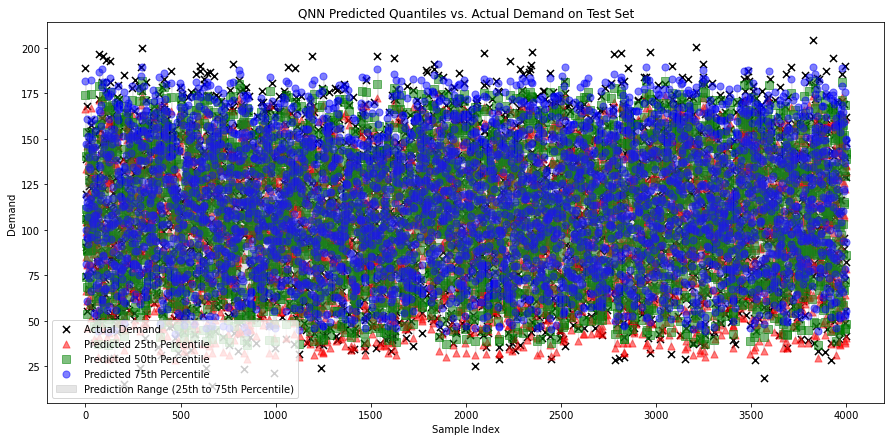

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure X_test_tensor is created from the test set
# Note: This should already be defined from when you performed the train-test split and evaluation.
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # This line is just a reminder.

# Assuming the model has been trained and is ready for evaluation
with torch.no_grad():
    model.eval()  # Ensure the model is in evaluation mode
    predictions_tensor = model(X_test_tensor)
    predictions = predictions_tensor.cpu().numpy()  # Convert to numpy for easier handling

# Select a product to visualize, for example, product 1
product_index = 0  # Change to 1 for product 2, if desired

# Extracting actual demands and predicted quantiles for the selected product from the test set
actual_demand = Y_test[:, product_index]  # Use Y_test for actual demands from the test set
pred_25th = predictions[:, product_index * 3]  # Adjust based on product index and output structure
pred_50th = predictions[:, product_index * 3 + 1]
pred_75th = predictions[:, product_index * 3 + 2]

# Indices for plotting
indices = np.arange(len(actual_demand))

plt.figure(figsize=(15, 7))

# Plot actual demands
plt.scatter(indices, actual_demand, color='black', label='Actual Demand', marker='x', s=50)

# Plot predicted quantiles
plt.scatter(indices, pred_25th, color='red', label='Predicted 25th Percentile', alpha=0.5, marker='^', s=50)
plt.scatter(indices, pred_50th, color='green', label='Predicted 50th Percentile', alpha=0.5, marker='s', s=50)
plt.scatter(indices, pred_75th, color='blue', label='Predicted 75th Percentile', alpha=0.5, marker='o', s=50)

# Optionally, add a fill between the 25th and 75th percentile predictions to highlight the prediction range
plt.fill_between(indices, pred_25th, pred_75th, color='gray', alpha=0.2, label='Prediction Range (25th to 75th Percentile)')

plt.title('QNN Predicted Quantiles vs. Actual Demand on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Demand')
plt.legend()
plt.show()



In [75]:
import numpy as np

# Ensure predictions are made on the test set and stored in `predictions`
# For this example, let's assume `predictions` were made using `X_test_tensor` as shown previously

# Extracting actual demands and predicted quantiles for the first product from the test set
actual_demand_product1 = Y_test[:, 0]  # Use Y_test for actual demands from the test set
pred_25th_percentile = predictions[:, 0]  # 25th percentile predictions for product 1
pred_75th_percentile = predictions[:, 2]  # 75th percentile predictions for product 1

# Counting the data points in the test set
total_points = len(actual_demand_product1)
above_75 = np.sum(actual_demand_product1 > pred_75th_percentile)
below_25 = np.sum(actual_demand_product1 < pred_25th_percentile)
between_25_75 = np.sum((actual_demand_product1 >= pred_25th_percentile) & (actual_demand_product1 <= pred_75th_percentile))

# Calculating percentages
percentage_above_75 = (above_75 / total_points) * 100
percentage_below_25 = (below_25 / total_points) * 100
percentage_between_25_75 = (between_25_75 / total_points) * 100

# Printing the results
print(f"Percentage of data points above the 75th percentile: {percentage_above_75:.2f}%")
print(f"Percentage of data points below the 25th percentile: {percentage_below_25:.2f}%")
print(f"Percentage of data points between the 25th and 75th percentiles: {percentage_between_25_75:.2f}%")



Percentage of data points above the 75th percentile: 25.87%
Percentage of data points below the 25th percentile: 21.05%
Percentage of data points between the 25th and 75th percentiles: 53.08%
